# Финальный проект: промышленность 

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Задача проекта — построить модель, которая будет её предсказывать. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install shap

In [3]:
!pip install imblearn

In [4]:
!pip install feature_engine 

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from feature_engine.selection import DropCorrelatedFeatures
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.linear_model import Lasso
import shap

In [6]:
!pip install scikit-learn --upgrade

In [7]:
import sklearn
sklearn.__version__

'1.3.2'

## Загрузка данных

In [8]:
# Напишем функции для просмотра основной информации о данных:
def view_data(data):
    print(data.info())
    print(' ')
    print(data.describe())

### Загрузим данные об электродах

In [9]:
data_arc_new = pd.read_csv('/datasets/data_arc_new.csv', parse_dates=[1,2])

In [10]:
data_arc_new.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


### Загрузим данные о подаче сыпучих материалов (объём)

In [11]:
data_bulk_new = pd.read_csv('/datasets/data_bulk_new.csv')

In [12]:
data_bulk_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


### Загрузим данные о подаче сыпучих материалов (время)

In [13]:
data_bulk_time_new = pd.read_csv('/datasets/data_bulk_time_new.csv', parse_dates=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

In [14]:
data_bulk_time_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


### Загрузим данные о продувке сплава газом

In [15]:
data_gas_new = pd.read_csv('/datasets/data_gas_new.csv')

In [16]:
data_gas_new.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


### Загрузим результаты измерения температуры

In [17]:
data_temp_new = pd.read_csv('/datasets/data_temp_new.csv', parse_dates=[1])

In [18]:
data_temp_new.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


### Загрузим данные о проволочных материалах (объём)

In [19]:
data_wire_new = pd.read_csv('/datasets/data_wire_new.csv')

In [20]:
data_wire_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Загрузим данные о проволочных материалах (время)

In [21]:
data_wire_time_new = pd.read_csv('/datasets/data_wire_time_new.csv', parse_dates=[1,2,3,4,5,6,7,8,9])

In [22]:
data_wire_time_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


**Вывод:** загрузили 7 наборов данных. Можно заметить, что в каждом содержатся пропуски, тип данных datetime определен как object, в разных наборах данных столбцы имееют одинаковые названия.

## Исследовательский анализ и предобработка данных

### Данные об электродах

In [23]:
view_data(data_arc_new)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB
None
 
                key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.662752             0.438986
std      934.571502           0.258885             5.873485
min        1.000000           0.223120          -715.479924
25%      806.000000           0.467115             0.337175
50%     1617.000000           0.599587          

In [24]:
# Посмотрим на долю пропусков в наборе данных
pd.DataFrame(round(data_arc_new.isna().mean().sort_values(ascending=False)*100,1)).style.background_gradient('coolwarm')

,0
key,0.000000
Начало нагрева дугой,0.000000
Конец нагрева дугой,0.000000
Активная мощность,0.000000
Реактивная мощность,0.000000


В данном датафрейме пропуски отсутсвуют. 

In [25]:
# Убедимся в отсутсвии явных дубликатов в данных об электродах
data_arc_new.duplicated().sum()

0

Из описательной статистики можно заметить, что для признака "реактивная мощность" стандартное отклонение равно 5.8, минимальное значение равно -715.5, а среднее - 0.439. Можно предположить, что в данном наборе присутсвуют выбросы (например, само минимальное значение). Для признака "активная мощность" размах небольшой - 1.241, отклонение равно 0.25 - достаточно низкое значение.

Удалим очевидный выброс из набора данных (значение реактивной мощности равно -715.48)

In [26]:
data_arc_new[data_arc_new['Реактивная мощность'] < -1]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [27]:
data_arc_new =data_arc_new[data_arc_new['key']!=2116]

data_arc_new = data_arc_new.drop(9780, axis=0)

In [28]:
#Обновим индексы
data_arc_new.reset_index(drop=True, inplace=True)

Произведем агрегацию данных по ключу

In [29]:
data_arc_new = data_arc_new.groupby('key').agg({'Начало нагрева дугой': ['first'], 'Конец нагрева дугой': ['last'],'Активная мощность' : ['mean'], 'Реактивная мощность' : ['mean']})


In [30]:
data_arc_new.reset_index(inplace= True)

In [31]:
stats1 = ['first','last']
data_arc_new.columns = ['key']+['arc_heating_{}'.format(stat) for stat in stats1]+['active_power']+['reactive_power']


In [32]:
# Добавим признак - время нагрева дугой
data_arc_new['arc_heating_time'] = data_arc_new['arc_heating_last'] - data_arc_new['arc_heating_first']
data_arc_new['arc_heating_time'] = data_arc_new['arc_heating_time'].apply(lambda x : round(x.total_seconds() / 60, 3))

Визуализируем данные

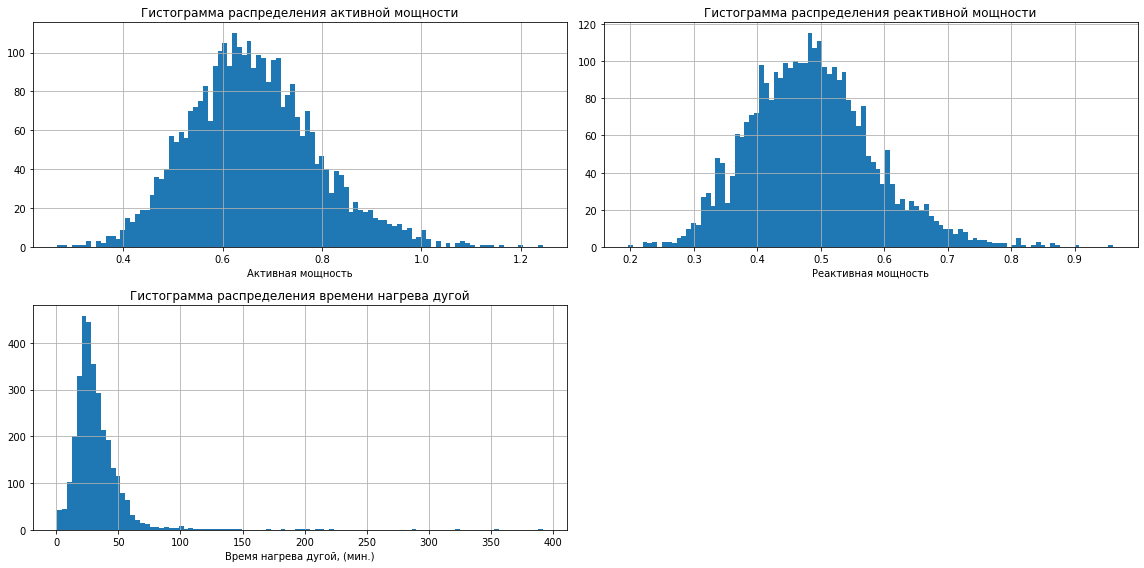

In [33]:
columns = ['active_power', 'reactive_power','arc_heating_time']
xlabels = ['Активная мощность', 'Реактивная мощность', 'Время нагрева дугой, (мин.)']
title = ['Гистограмма распределения активной мощности', 'Гистограмма распределения реактивной мощности', 'Гистограмма распределения времени нагрева дугой']
fig = plt.figure(figsize=(16,8))
for i in range (len(columns)):
    fig.add_subplot(2, 2, i+1)
    data_arc_new[columns[i]].hist(bins=100)
    plt.title(title[i])
    plt.xlabel(xlabels[i])
    plt.tight_layout()

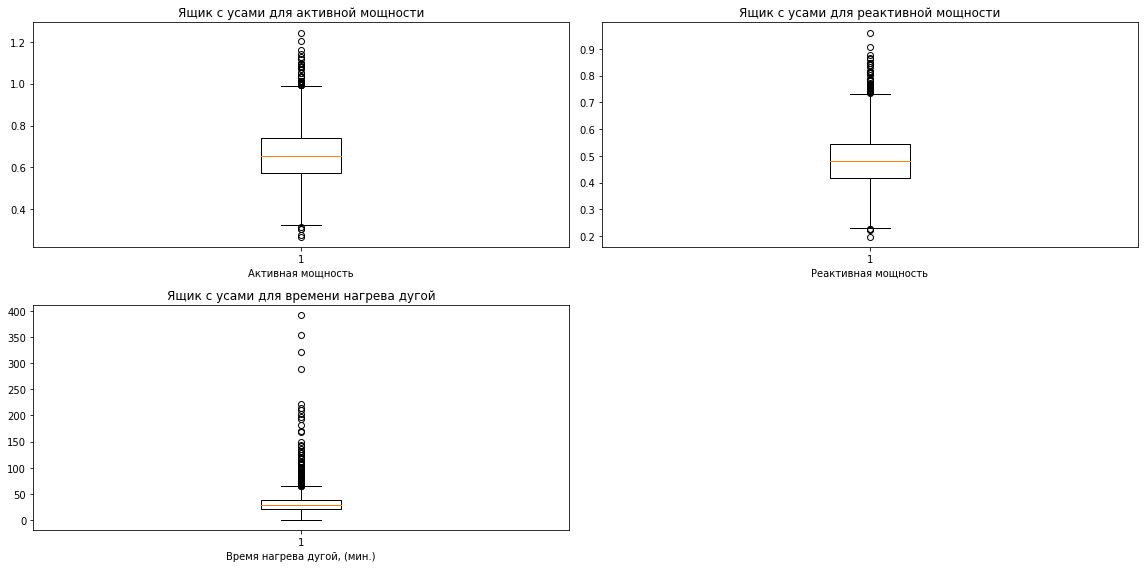

In [34]:
columns = ['active_power', 'reactive_power', 'arc_heating_time']
xlabels = ['Активная мощность', 'Реактивная мощность', 'Время нагрева дугой, (мин.)']
title = ['Ящик с усами для активной мощности', 'Ящик с усами для реактивной мощности', 'Ящик с усами для времени нагрева дугой']
fig = plt.figure(figsize=(16,8))
for i in range (len(columns)):
    fig.add_subplot(2, 2, i+1)
    plt.boxplot(x=data_arc_new[columns[i]])
    plt.title(title[i])
    plt.xlabel(xlabels[i])
    plt.tight_layout()

In [35]:
# Добавим признак - полная мощность
data_arc_new['power'] = (data_arc_new['active_power']**2 + data_arc_new['reactive_power']**2)**0.5

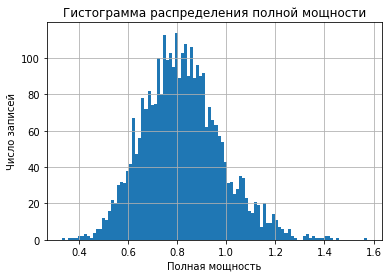

In [36]:
# Посмотрим на распределение этого признака
data_arc_new['power'].hist(bins=100)
plt.title('Гистограмма распределения полной мощности')
plt.xlabel('Полная мощность')
plt.ylabel('Число записей')
plt.show();

Можно заметить, что данное распределение так же стремится к нормальному.

In [37]:
# Удалим колонки arc_heating_first и arc_heating_last
columns_to_drop = ['arc_heating_first', 'arc_heating_last']
data_arc_new = data_arc_new.drop(columns=columns_to_drop)

In [38]:
data_arc_new.head()

,key,active_power,reactive_power,arc_heating_time,power
0,1,0.607346,0.428564,26.383,0.743328
1,2,0.534852,0.363339,19.067,0.646593
2,3,0.812728,0.587491,25.417,1.002833
3,4,0.676622,0.514248,18.217,0.849864
4,5,0.563238,0.421998,22.700,0.703789


Исходя из построенных графиков можно заметить, что большее количество записей приходится на диапозон активной мощности от 0.5 до 0.7 и на диапозон реактивной мощности от 0.375 до 0.55. Оба распределения имеют нормальный вид.

К тому же в данных все еще присутсвуют выбросы (их обработка будет реализована после объединения всех таблиц)

**Вывод:** для набора данных об электродах мы:
1. Избавились от выброса (запись с низким значением реактивной мощности)
2. Сгруппировали данные по ключу, расчитали для каждого ключа средние значения активной и реактивной мощностей, узнали время начала нагрева дугой и время конца нагрева дугой
3. Добавили новые признаки - время нагрева дугой (выраженное в минутах) и полная мощность
4. Построили гистограммы распределения мощностей и времени нагрева дугой

### Данные о подаче сыпучих материалов (объём)

In [39]:
view_data(data_bulk_new)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None
 
               key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean 

In [40]:
# Посмотрим на долю пропусков в наборе данных
pd.DataFrame(round(data_bulk_new.isna().mean().sort_values(ascending=False)*100,1)).style.background_gradient('coolwarm')

,0
Bulk 8,100.000000
Bulk 13,99.400000
Bulk 9,99.400000
Bulk 2,99.300000
Bulk 7,99.200000
Bulk 5,97.500000
Bulk 10,94.400000
Bulk 11,94.300000
Bulk 1,91.900000
Bulk 6,81.600000


Заметим, что доля пропусков во всех столбцах достаточно высока. Пропуск в данном случае означает, что добавки не добавляли, заполним пропуски нулями.

In [41]:
#Добавим новый признак - сумму всех добавок для каждой партии
columns_to_use = data_bulk_new.drop(columns=['key']).columns.to_list()
data_bulk_new['bulk_total'] = data_bulk_new[columns_to_use].sum(axis=1)

In [42]:
data_bulk_new = data_bulk_new.fillna(0)
print('Количество пропусков:', data_bulk_new.isna().sum())

Количество пропусков: key           0
Bulk 1        0
Bulk 2        0
Bulk 3        0
Bulk 4        0
Bulk 5        0
Bulk 6        0
Bulk 7        0
Bulk 8        0
Bulk 9        0
Bulk 10       0
Bulk 11       0
Bulk 12       0
Bulk 13       0
Bulk 14       0
Bulk 15       0
bulk_total    0
dtype: int64


In [43]:
# Убедимся в отсутсвии явных дубликатов в наборе данных
data_bulk_new.duplicated().sum()

0

Посмотрим, как распределялись данные для трех признаков, в которых было меньше всего пропусков.

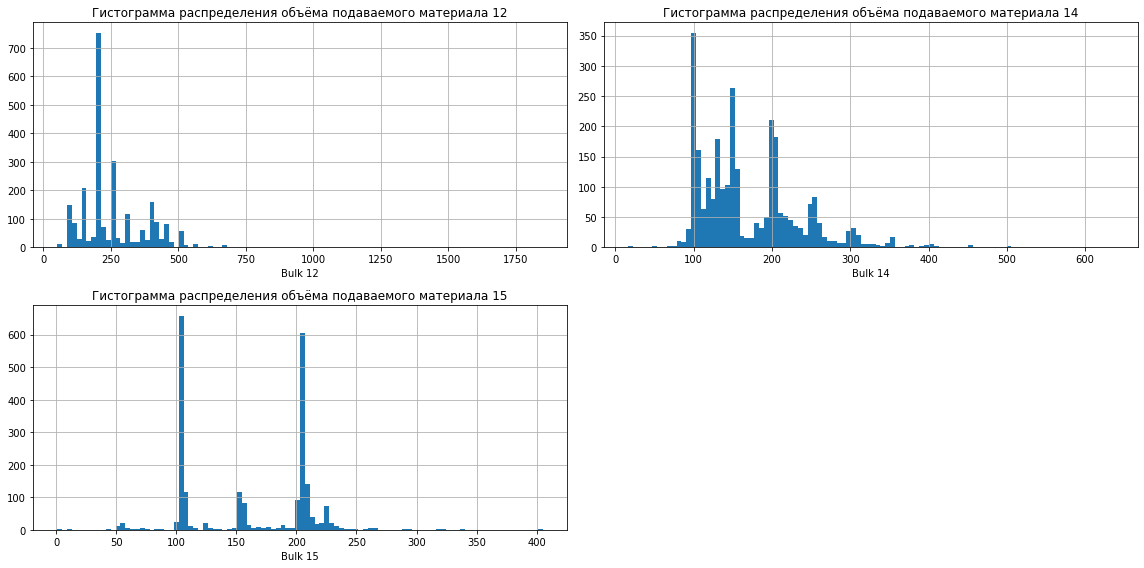

In [44]:
columns = ['Bulk 12', 'Bulk 14', 'Bulk 15']
title = ['Гистограмма распределения объёма подаваемого материала 12', 'Гистограмма распределения объёма подаваемого материала 14', 'Гистограмма распределения объёма подаваемого материала 15']
fig = plt.figure(figsize=(16,8))
for i in range(len(columns)):
    fig.add_subplot(2, 2, i+1)
    data_bulk_new[data_bulk_new[columns[i]] > 0][columns[i]].hist(bins=100)
    plt.title(title[i])
    plt.xlabel(columns[i])
    plt.tight_layout()

Распределение данные показатели имеют прерывистое.

### Данные о подаче сыпучих материалов (время)

In [45]:
view_data(data_bulk_time_new)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB
None
 
               k

In [46]:
# Посмотрим на долю пропусков в наборе данных
pd.DataFrame(round(data_bulk_time_new.isna().mean().sort_values(ascending=False)*100,1)).style.background_gradient('coolwarm')

,0
Bulk 8,100.000000
Bulk 13,99.400000
Bulk 9,99.400000
Bulk 2,99.300000
Bulk 7,99.200000
Bulk 5,97.500000
Bulk 10,94.400000
Bulk 11,94.300000
Bulk 1,91.900000
Bulk 6,81.600000


Аналогично предыдущему набору данных доля пропусков в столбцах высока. Данная таблица для дальнейшего построения пайплайна использоваться не будет. 

In [47]:
# Убедимся в отсутсвии явных дубликатов в наборе данных
data_bulk_time_new.duplicated().sum()

0

### Данные о продувке сплава газом

In [48]:
view_data(data_gas_new)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None
 
               key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040


In [49]:
# Посмотрим на долю пропусков в наборе данных
pd.DataFrame(round(data_gas_new.isna().mean().sort_values(ascending=False)*100,1)).style.background_gradient('coolwarm')

,0
key,0.000000
Газ 1,0.000000


In [50]:
# Убедимся в отсутсвии явных дубликатов в наборе данных
data_gas_new.duplicated().sum()

0

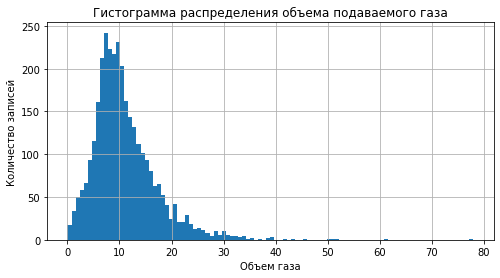

In [51]:
data_gas_new['Газ 1'].hist(bins=100, figsize=(8,4))
plt.title('Гистограмма распределения объема подаваемого газа')
plt.xlabel('Объем газа')
plt.ylabel('Количество записей')
plt.show();

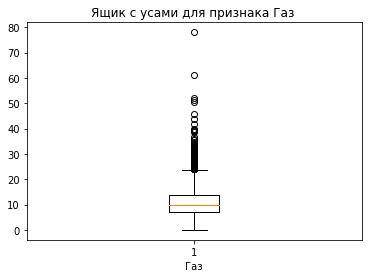

In [52]:
# Посмотрим на выбросы в данном датафрейме
plt.boxplot(x=data_gas_new['Газ 1'])
plt.xlabel('Газ')
plt.title('Ящик с усами для признака Газ ')
plt.show();

Можно заметить, что чаще всего объем подаваемого газа варьируется от 5 до 15. Распределение так же стремится к нормальному, однако встречаются и редкие значения объема (те, что больше 50). С помощью ящика с усами определили, что в датафрейме имеются выбросы.

### Результаты измерения температуры

In [53]:
view_data(data_temp_new)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB
None
 
                key   Температура
count  18092.000000  14665.000000
mean    1616.460977   1590.722741
std      934.641385     20.394381
min        1.000000   1191.000000
25%      807.750000   1580.000000
50%     1618.000000   1590.000000
75%     2429.000000   1599.000000
max     3241.000000   1705.000000


In [54]:
# Посмотрим на долю пропусков в наборе данных
pd.DataFrame(round(data_temp_new.isna().mean().sort_values(ascending=False)*100,1)).style.background_gradient('coolwarm')

,0
Температура,18.900000
key,0.000000
Время замера,0.000000


Согласно специфике технологического процесса, температура ниже 1500 считается аномалией. Отфильтруем набор данных по заданному условию.

In [55]:
keys_to_drop = data_temp_new[data_temp_new['Температура'] < 1500]['key'].to_list()

In [56]:
data_temp_new = data_temp_new[~data_temp_new['key'].isin(keys_to_drop)] 

Посмотрим на распределение температуры

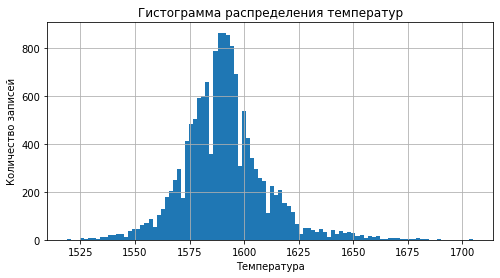

In [57]:
data_temp_new['Температура'].hist(bins=100, figsize=(8,4))
plt.title('Гистограмма распределения температур')
plt.xlabel('Температура')
plt.ylabel('Количество записей')
plt.show();

Можно заметить, что распределение температуры стремится к нормальному, однако в некоторых местах количество записей падает, а затем снова возрастает.

In [58]:
# Убедимся в отсутсвии явных дубликатов в наборе данных
data_temp_new.duplicated().sum()

0

Добавим в таблицу новые столбцы - первичная температура, количество замеров ,финальная температура и начальное и последнее время замера

In [59]:
data_temp_new = data_temp_new.groupby('key').agg({'Время замера': ['first', 'last', 'count'], 'Температура': ['first', 'last']})


In [60]:
data_temp_new.reset_index(inplace= True)

In [61]:
data_temp_new.head()

key        Время замера                           Температура        
                    first                last count       first    last
0   1 2019-05-03 11:02:04 2019-05-03 11:30:38     6      1571.0  1613.0
1   2 2019-05-03 11:34:04 2019-05-03 11:55:09     5      1581.0  1602.0
2   3 2019-05-03 12:06:44 2019-05-03 12:35:57     6      1596.0  1599.0
3   4 2019-05-03 12:39:27 2019-05-03 12:59:47     5      1601.0  1625.0
4   5 2019-05-03 13:11:03 2019-05-03 13:36:39     5      1576.0  1602.0

In [62]:
# Для удобства переименуем колонки
stats = ['first','last']
data_temp_new.columns = ['key']+['time_{}'.format(stat) for stat in stats]+ ['heating_count'] +['temp_{}'.format(stat) for stat in stats]

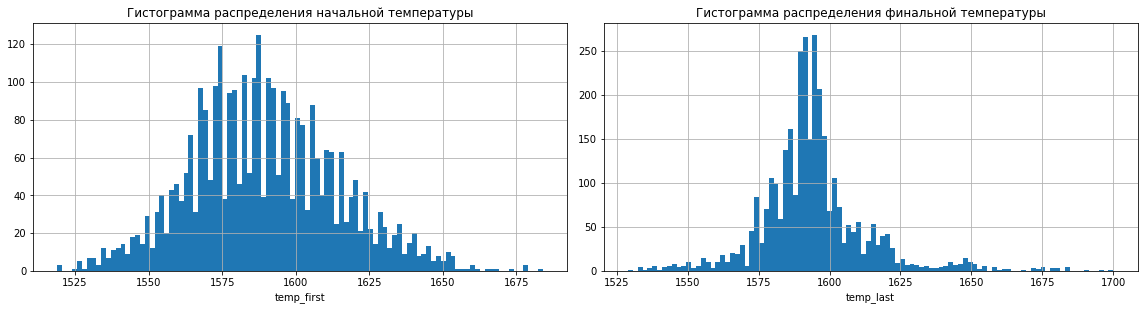

In [63]:
columns = ['temp_first', 'temp_last']
title = ['Гистограмма распределения начальной температуры', 'Гистограмма распределения финальной температуры']
fig = plt.figure(figsize=(16,8))
for i in range (len(columns)):
    fig.add_subplot(2, 2, i+1)
    data_temp_new[columns[i]].hist(bins=100)
    plt.title(title[i])
    plt.xlabel(columns[i])
    plt.tight_layout()

Гистограммы начальной и конечной температур имеют прерывистый вид, хоть и стремятся к нормальному распределению.

In [64]:
data_temp_new = data_temp_new[data_temp_new['key'] <= 2500]

In [65]:
# Добавим новый признак - время нагрева
#data_temp_new = data_temp_new[data_temp_new['time_first'] != data_temp_new['time_last']]
data_temp_new['heating_time'] = data_temp_new['time_last'] - data_temp_new['time_first']

In [66]:
data_temp_new['heating_time'] = data_temp_new['heating_time'].apply(lambda x : round(x.total_seconds() / 60, 3))

In [67]:
# Удалим колонки - time_first и time_last
columns_to_drop = ['time_first', 'time_last']
data_temp_new = data_temp_new.drop(columns=columns_to_drop)

In [68]:
data_temp_new.head()

,key,heating_count,temp_first,temp_last,heating_time
0,1,6,1571.0,1613.0,28.567
1,2,5,1581.0,1602.0,21.083
2,3,6,1596.0,1599.0,29.217
3,4,5,1601.0,1625.0,20.333
4,5,5,1576.0,1602.0,25.600


In [69]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2474 entries, 0 to 2473
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            2474 non-null   int64  
 1   heating_count  2474 non-null   int64  
 2   temp_first     2474 non-null   float64
 3   temp_last      2474 non-null   float64
 4   heating_time   2474 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 116.0 KB


**Вывод:** для набора данных о результатах измерения температуры:
1. Избавились от выбросов - значения температуры ниже 1500 градусов, а так же от записей с одним измерением температуры
2. Произвели агрегацию данных по клучу: вычислили начальное и конечное время замера температуры, начальную и конечную температуру
3. Добавили новые признаки - время нагрева (в минутах), количество замеров температуры
4. Посмотрели на распределения показателей

### Данные о проволочных материалах (объём)

In [70]:
# Посмотрим на долю пропусков в наборе данных
pd.DataFrame(round(data_wire_new.isna().mean().sort_values(ascending=False)*100,1)).style.background_gradient('coolwarm')

,0
Wire 5,100.000000
Wire 7,99.600000
Wire 4,99.500000
Wire 8,99.400000
Wire 9,99.100000
Wire 3,98.000000
Wire 6,97.600000
Wire 2,65.000000
Wire 1,0.800000
key,0.000000


Аналогично набору данных data_bulk_new, пропуски означают то, что добавки не добавлялись, заполним пропуски нулями.

In [71]:
data_wire_new = data_wire_new.fillna(0)
print('Число пропусков:', data_wire_new.isna().sum())

Число пропусков: key       0
Wire 1    0
Wire 2    0
Wire 3    0
Wire 4    0
Wire 5    0
Wire 6    0
Wire 7    0
Wire 8    0
Wire 9    0
dtype: int64


In [72]:
# Убедимся в отсутсвии явных дубликатов в наборе данных
data_wire_new.duplicated().sum()

0

Доля пропусков в столбце 'Wire 1' мала, построим гистограмму для данной величины.

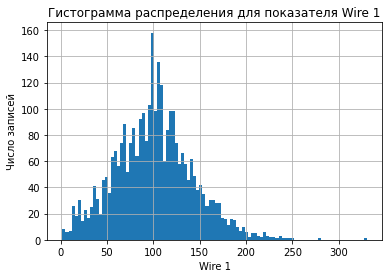

In [73]:
data_wire_new[data_wire_new['Wire 1'] > 0]['Wire 1'].hist(bins=100)
plt.title('Гистограмма распределения для показателя Wire 1')
plt.xlabel('Wire 1')
plt.ylabel('Число записей')
plt.show();

Данный признак распределен нормально. Больше всего объем подаваемого проволочного материала варьировался от 75 до 125.

In [74]:
#Добавим новый признак - сумма объемов подаваемых проволочных материалов для каждой партии
columns_to_use = data_wire_new.drop(columns=['key']).columns.to_list()
data_wire_new['wire_total'] = data_wire_new[columns_to_use].sum(axis=1)

In [75]:
data_wire_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,wire_total
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796


### Данные о проволочных материалах (время)

In [76]:
view_data(data_wire_time_new)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB
None
 
               key
count  3081.000000
mean   1623.426485
std     932.996726
min       1.000000
25%     823.000000
50%    1619.000000
75%    2434.000000
max    3241.000000


In [77]:
# Посмотрим на долю пропусков в наборе данных
pd.DataFrame(round(data_wire_time_new.isna().mean().sort_values(ascending=False)*100,1)).style.background_gradient('coolwarm')

,0
Wire 5,100.000000
Wire 7,99.600000
Wire 4,99.500000
Wire 8,99.400000
Wire 9,99.100000
Wire 3,98.000000
Wire 6,97.600000
Wire 2,65.000000
Wire 1,0.800000
key,0.000000


In [78]:
# Убедимся в отсутсвии явных дубликатов в наборе данных
data_wire_time_new.duplicated().sum()

0

## Объединение данных

In [79]:
# Объединим данные по столбцу key
data_final = data_arc_new.merge(data_bulk_new, how='inner', on='key')
data_final = data_final.merge(data_gas_new, how='inner', on='key')
data_final = data_final.merge(data_temp_new, how='inner', on='key')
data_final = data_final.merge(data_wire_new, how='inner', on='key')

In [80]:
data_final = data_final[data_final['key'] <= 2500]

In [81]:
data_final.drop(columns=['key'], inplace=True)

## Исследовательский анализ и предобработка данных объединённого датафрейма

In [82]:
view_data(data_final)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   active_power      2325 non-null   float64
 1   reactive_power    2325 non-null   float64
 2   arc_heating_time  2325 non-null   float64
 3   power             2325 non-null   float64
 4   Bulk 1            2325 non-null   float64
 5   Bulk 2            2325 non-null   float64
 6   Bulk 3            2325 non-null   float64
 7   Bulk 4            2325 non-null   float64
 8   Bulk 5            2325 non-null   float64
 9   Bulk 6            2325 non-null   float64
 10  Bulk 7            2325 non-null   float64
 11  Bulk 8            2325 non-null   float64
 12  Bulk 9            2325 non-null   float64
 13  Bulk 10           2325 non-null   float64
 14  Bulk 11           2325 non-null   float64
 15  Bulk 12           2325 non-null   float64
 16  Bulk 13           2325 non-null   float64


In [83]:
data_final.describe().T

,count,mean,std,min,25%,50%,75%,max
active_power,2325.0,0.664165,0.128408,0.267676,0.575890,0.655642,0.741868,1.243889
reactive_power,2325.0,0.488883,0.098021,0.196228,0.420005,0.484647,0.546687,0.960763
arc_heating_time,2325.0,33.214292,22.517123,0.950000,22.067000,29.067000,39.950000,391.417000
power,2325.0,0.824941,0.160282,0.331897,0.713628,0.817599,0.920695,1.571727
Bulk 1,2325.0,3.433548,12.421994,0.000000,0.000000,0.000000,0.000000,185.000000
Bulk 2,2325.0,1.424946,19.098442,0.000000,0.000000,0.000000,0.000000,325.000000
Bulk 3,2325.0,47.315699,75.221893,0.000000,0.000000,0.000000,80.000000,454.000000
Bulk 4,2325.0,37.331613,58.670377,0.000000,0.000000,0.000000,77.000000,281.000000
Bulk 5,2325.0,2.644731,22.421296,0.000000,0.000000,0.000000,0.000000,603.000000
Bulk 6,2325.0,22.409892,55.782442,0.000000,0.000000,0.000000,0.000000,503.000000


In [84]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   active_power      2325 non-null   float64
 1   reactive_power    2325 non-null   float64
 2   arc_heating_time  2325 non-null   float64
 3   power             2325 non-null   float64
 4   Bulk 1            2325 non-null   float64
 5   Bulk 2            2325 non-null   float64
 6   Bulk 3            2325 non-null   float64
 7   Bulk 4            2325 non-null   float64
 8   Bulk 5            2325 non-null   float64
 9   Bulk 6            2325 non-null   float64
 10  Bulk 7            2325 non-null   float64
 11  Bulk 8            2325 non-null   float64
 12  Bulk 9            2325 non-null   float64
 13  Bulk 10           2325 non-null   float64
 14  Bulk 11           2325 non-null   float64
 15  Bulk 12           2325 non-null   float64
 16  Bulk 13           2325 non-null   float64


In [85]:
#Приведем колонки к snake case
data_final = data_final.rename(columns={'Газ 1' : 'gas_1'})
data_final.columns = data_final.columns.str.lower()
data_final.columns = data_final.columns.str.replace(' ', '_') 

In [86]:
#Добавим новый признак - отношение объема газа к количеству нагревов
data_final['gas_1_div_heating_count'] = data_final['gas_1'] / data_final['heating_count']

In [87]:
#Добавим новый признак - отношение время нагрева к количеству измерений
data_final['heating_time_div_heating_count'] = data_final['heating_time'] / data_final['heating_count']

In [88]:
#Добавим новые признаки - отношения объема газа к подаваемым материалам
data_final['gas_1_div_wire_total'] = data_final['gas_1'] / data_final['wire_total']

In [89]:
#Добавим новый признак - отношение отношение объёма подаваемых проволочных материалов к объёму подаваемого материала
data_final['wire_total_div_bulk_total'] = data_final['wire_total'] / data_final['bulk_total']

In [90]:
#Добавим новый признак - отношение полной мощности к количеству нагреваний
data_final['power_div_heating_count'] = data_final['power'] / data_final['heating_count']

In [91]:
data_final.head()

,active_power,reactive_power,arc_heating_time,power,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,wire_6,wire_7,wire_8,wire_9,wire_total,gas_1_div_heating_count,heating_time_div_heating_count,gas_1_div_wire_total,wire_total_div_bulk_total,power_div_heating_count
0,0.607346,0.428564,26.383,0.743328,0.0,0.0,0.0,43.0,0.0,0.0,...,0.0,0.0,0.0,0.0,60.059998,4.958331,4.761167,0.495338,0.108608,0.123888
1,0.534852,0.363339,19.067,0.646593,0.0,0.0,0.0,73.0,0.0,0.0,...,0.0,0.0,0.0,0.0,96.052315,2.511112,4.216600,0.130716,0.165038,0.129319
2,0.812728,0.587491,25.417,1.002833,0.0,0.0,0.0,34.0,0.0,0.0,...,0.0,0.0,0.0,0.0,91.160157,4.759132,4.869500,0.313238,0.167574,0.167139
3,0.676622,0.514248,18.217,0.849864,0.0,0.0,0.0,81.0,0.0,0.0,...,0.0,0.0,0.0,0.0,89.063515,3.768244,4.066600,0.211548,0.149687,0.169973
4,0.563238,0.421998,22.700,0.703789,0.0,0.0,0.0,78.0,0.0,0.0,...,0.0,0.0,0.0,0.0,98.352796,1.082738,5.120000,0.055044,0.168412,0.140758


In [92]:
data_final.shape

(2325, 40)

### Проведем корреляционный анализ 

In [94]:
corr = data_final.corr()

In [95]:
#Посмотрим на значения корреляций, которые больше всего влияют на наш таргет -  temp_last
target = 'temp_last'
corr_target = corr[corr > 0.1][target].sort_values()
corr_target = corr_target.dropna()
corr_target = corr_target[corr_target != 1.]
corr_columns = corr_target.index.to_list()

In [96]:
target = 'temp_last'
corr_target_zero = corr[corr.abs() < 0.04][target]
corr_target_zero = corr_target_zero .dropna()

In [97]:
corr_target_zero = corr_target_zero.index.to_list()

In [98]:
corr_target

arc_heating_time    0.114491
bulk_14             0.115178
heating_count       0.180264
bulk_4              0.188179
bulk_total          0.220700
bulk_15             0.261750
bulk_12             0.264845
temp_first          0.304343
wire_1              0.316798
Name: temp_last, dtype: float64

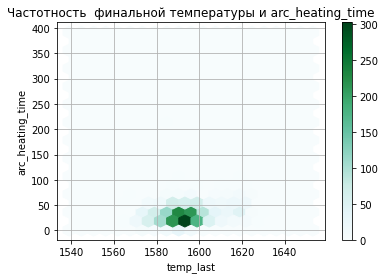

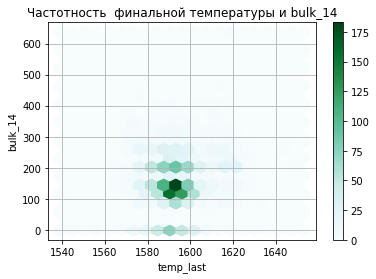

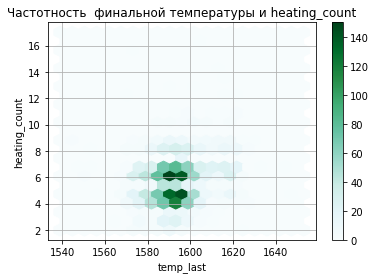

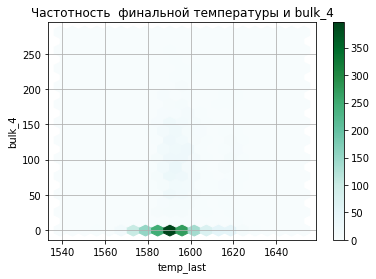

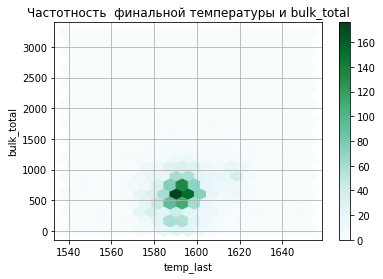

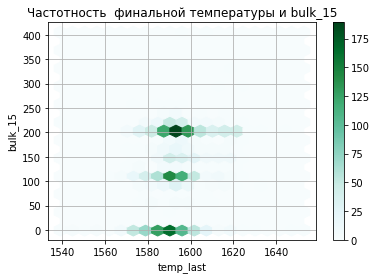

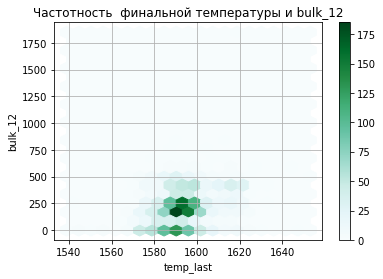

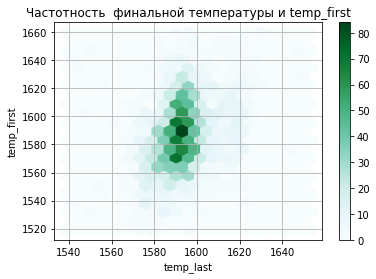

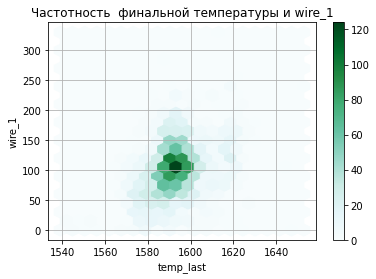

In [99]:
columns = corr_columns
for i in range(len(columns)):
    data_final.plot(x='temp_last', y=columns[i], kind='hexbin', gridsize=20, figsize=(6, 4), sharex=False, grid=True)
    plt.title(f'Частотность  финальной температуры и {columns[i]}')
    plt.ylabel(columns[i])
    plt.show();


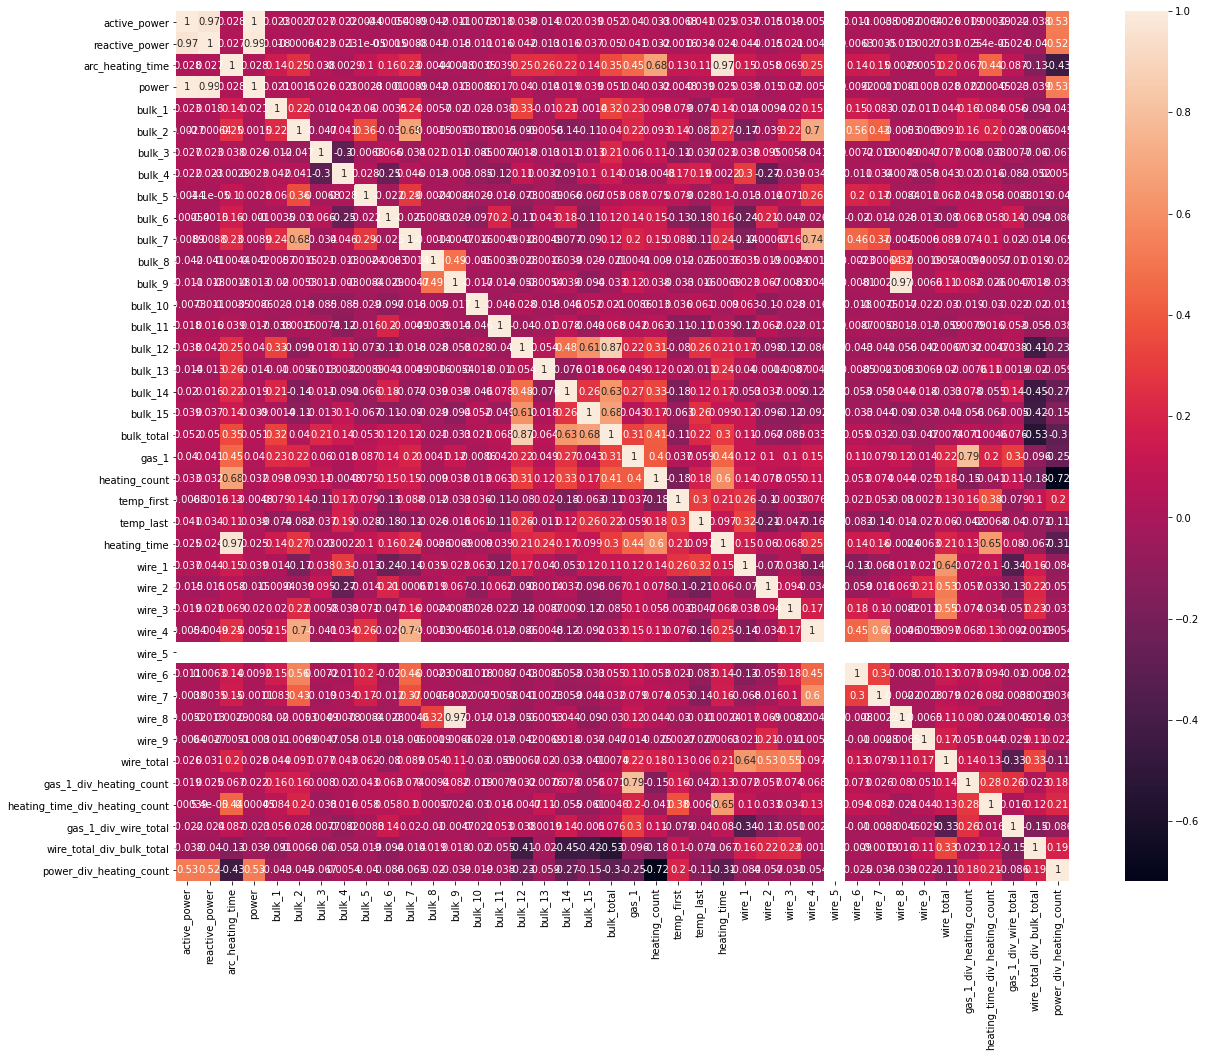

In [100]:
# Построим heatmap для матрицы корреляций всех признаков
plt.figure(figsize=(20,16))
sns.heatmap(corr, annot=True)
plt.show();

Можно заметить, что:
1. Больше всего на target влияет признак 'wire_1'
2. Между следующими признаками наблюдается высокая корреляция (больше 0.8): bulk 9 и wire 8, arc_heating_time и heating_time, active_power и reactive_power.

## Подготовка данных

In [101]:
state = np.random.RandomState(121223)

### Разбивка данных на обучающую и тестовую выборку

In [102]:
cols_to_drop = ['bulk_8', 'wire_5', 'active_power', 'reactive_power']
data_final = data_final.drop(columns=cols_to_drop)

In [103]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 36 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   arc_heating_time                2325 non-null   float64
 1   power                           2325 non-null   float64
 2   bulk_1                          2325 non-null   float64
 3   bulk_2                          2325 non-null   float64
 4   bulk_3                          2325 non-null   float64
 5   bulk_4                          2325 non-null   float64
 6   bulk_5                          2325 non-null   float64
 7   bulk_6                          2325 non-null   float64
 8   bulk_7                          2325 non-null   float64
 9   bulk_9                          2325 non-null   float64
 10  bulk_10                         2325 non-null   float64
 11  bulk_11                         2325 non-null   float64
 12  bulk_12                         23

In [104]:
features = data_final.drop(columns=['temp_last'])
target = data_final['temp_last']

In [105]:
features.head()

,arc_heating_time,power,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,...,wire_6,wire_7,wire_8,wire_9,wire_total,gas_1_div_heating_count,heating_time_div_heating_count,gas_1_div_wire_total,wire_total_div_bulk_total,power_div_heating_count
0,26.383,0.743328,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,60.059998,4.958331,4.761167,0.495338,0.108608,0.123888
1,19.067,0.646593,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,96.052315,2.511112,4.216600,0.130716,0.165038,0.129319
2,25.417,1.002833,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,91.160157,4.759132,4.869500,0.313238,0.167574,0.167139
3,18.217,0.849864,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,89.063515,3.768244,4.066600,0.211548,0.149687,0.169973
4,22.700,0.703789,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,98.352796,1.082738,5.120000,0.055044,0.168412,0.140758


In [106]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=state)

## Обучение моделей машинного обучения

Построим пайплайн для обучения моделей случайного леса, модели LightGBM, Lasso (пайплайн масштабирует численные признаки, удаляет высококоррелирующие признаки, подбирает гиперпараметры модели)

In [107]:
def train(model, params):
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('drop', DropCorrelatedFeatures()),
        ('model', model)])
    grid_search = RandomizedSearchCV(pipeline, params, n_iter=30, cv=5, n_jobs =-1, verbose=0, scoring='neg_mean_absolute_error')
    grid_search.fit(features_train, target_train)
    print('Наилучшая мера MAE:', -grid_search.best_score_)
    print('Наилучшие параметры:', grid_search.best_params_)
    return grid_search

In [109]:
params = {
        'model__n_estimators': range(1, 203, 2),
        'drop__threshold': [0.6, 0.7, 0.8, 0.9],
        'model__max_depth': range(1, 203, 2),
        'model__learning_rate' : [0.1, 0.01, 0.05, 0.001],
        'model__num_leaves' : range(1, 103, 2),
    }
model_lgb = train(LGBMRegressor(random_state=state), params)

Наилучшая мера MAE: 6.806514981693882
Наилучшие параметры: {'model__num_leaves': 9, 'model__n_estimators': 103, 'model__max_depth': 31, 'model__learning_rate': 0.05, 'drop__threshold': 0.9}


In [110]:
params = {
    'model__n_estimators': range(1, 102, 10),
    'model__max_depth': range(1, 63, 2),
    'model__max_features': [None, 'sqrt', 5,]
    }
model_rf = train(RandomForestRegressor(random_state=state), params)

Наилучшая мера MAE: 6.939084749193947
Наилучшие параметры: {'model__n_estimators': 101, 'model__max_features': None, 'model__max_depth': 13}


In [111]:
params = {
    'model__alpha': [1, 10, 100]
    }
model_l = train(Lasso(random_state=state), params)

Наилучшая мера MAE: 8.03778541740218
Наилучшие параметры: {'model__alpha': 1}


In [112]:
model_lgb.best_estimator_[-1]

LGBMRegressor(learning_rate=0.05, max_depth=31, n_estimators=103, num_leaves=9,
              random_state=RandomState(MT19937) at 0x7FB44B56ED40)

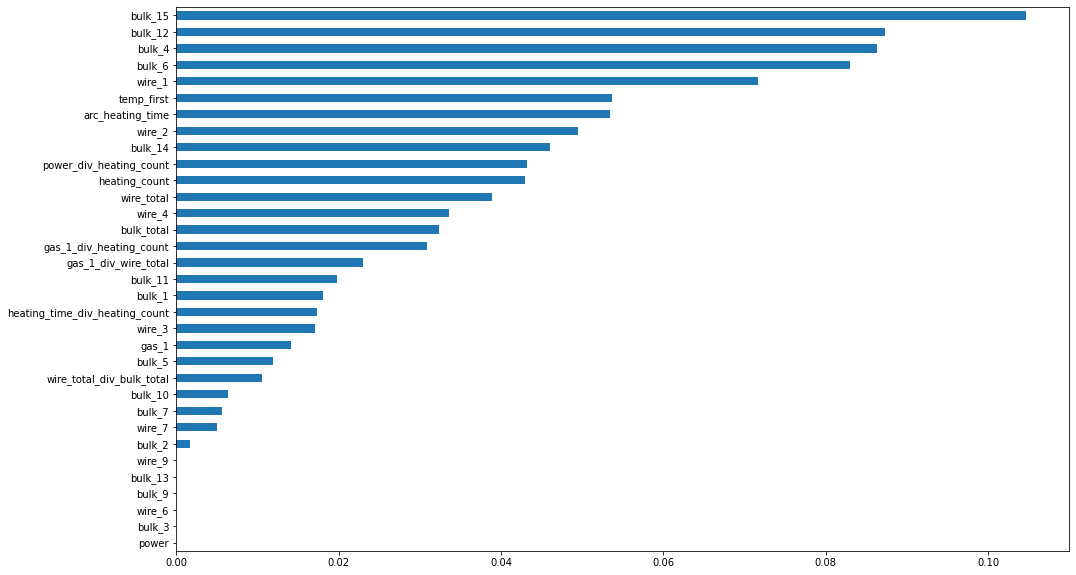

In [113]:
# Значимость признаков
preprocess_pipeline = model_lgb.best_estimator_[:-1]
x = preprocess_pipeline.fit_transform(features_train, target_train)
mi = mutual_info_classif(x, target_train, random_state=state)
#mi = mutual_info_classif(features_train, target_train, random_state=state)
feature_names = preprocess_pipeline.get_feature_names_out()
pd.Series(mi, index=feature_names).sort_values().plot(kind='barh', figsize=(16,10))
plt.show()

## Выбор лучшей модели

Получили, что модель LightGBM на тренировочной выборке имеет наилучшее значение метрики MAE. Протестируем данную модель на обучающей выборке:

In [114]:
predictions_test = model_lgb.predict(features_test)
print('Метрика MAE для тестовой выборки:', mean_absolute_error(target_test, predictions_test))

Метрика MAE для тестовой выборки: 6.756770102373645


**Вывод:** таким образом, для реализации проекта были выполнены следующие шаги:
1. Был реализован первичный анализ данных: заполнены пропуски, построены гистограммы, проведен корреляционный анализ, данные были сагрегированны
2. Были сгенерированы новые признаки
3. Был построен пайплайн, масштабирующий признаки, удаляющий высокоскорелированные признаки и подбирающий наилучшие гиперпараметры для моделей: LightGBM, случайный лес и Lasso.
4. Наилучшей оказалась модель LightGBM. Однако на тестовой выборке метрика MAE равна 6.757, то есть в среднем модель ошибается на 6.7 градусов при предсказывании температуры. Для улучшения данной метрики можно попробовать построить другие модель МО, сгенерировать новые признаки, получить больше данных с производства.